In [1]:
import numpy as np
from scipy.signal import chirp, hilbert
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 1. OscillTrack implementation
# ---------------------------------------------------------------------
class OscillTrack:
    """
    Real-time phase tracker inspired by McNamara et al. (2022).
    All calculations use float64 for clarity; if porting to embedded
    hardware replace the trig calls with a lookup table as described
    in the paper.
    """

    def __init__(self, fc_hz: float, fs_hz: float, g: float = 2 ** -4):
        """
        Parameters
        ----------
        fc_hz : centre frequency to track (Hz)
        fs_hz : sample rate (Hz)
        g     : error update coefficient (pass-band width controller)
        """
        self.fc = fc_hz
        self.fs = fs_hz
        self.g = g

        # Iterative state
        self.a = 0.0
        self.b = 0.0
        self.theta = 0.0                    # reference phase
        self.dtheta = 2 * np.pi * self.fc / self.fs  # phase step per sample

    def step(self, s: float):
        """
        Update the tracker with one new sample and return
        (phase_estimate_rad, amplitude_estimate).
        """
        sin_t = np.sin(self.theta)
        cos_t = np.cos(self.theta)

        # Complex estimate r_n  (eq. 2)  -------------------------------
        r_real = self.a * sin_t + self.b * cos_t
        r_imag = self.b * sin_t - self.a * cos_t

        # Error term D_n  (eq. 3) --------------------------------------
        D = s - r_real

        # Update coefficients a_{n+1}, b_{n+1}  (eq. 4) ----------------
        self.a += self.g * D * sin_t
        self.b += self.g * D * cos_t

        # Phase (CORDIC in hardware; arctan2 here)  --------------------
        phase = np.arctan2(r_imag, r_real)  # φ_n in paper
        amplitude = np.hypot(self.a, self.b)

        # Advance reference phase
        self.theta += self.dtheta
        if self.theta >= 2 * np.pi:         # cheap modulo 2π
            self.theta -= 2 * np.pi

        return phase, amplitude


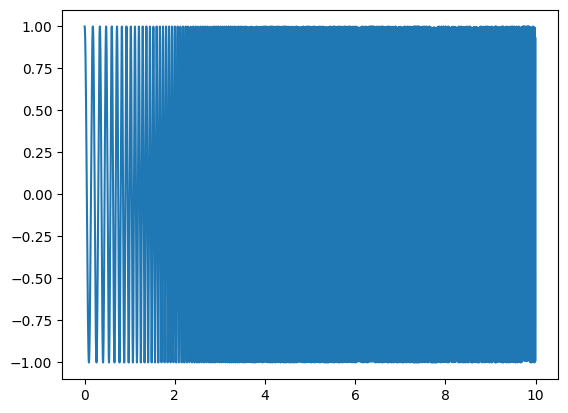

In [4]:

# ---------------------------------------------------------------------
# 2. Create a linear chirp that sweeps through 30 Hz
# ---------------------------------------------------------------------
fs = 1000            # Hz
duration = 10.0       # s
t = np.arange(int(duration * fs)) / fs
signal = chirp(t, f0=5, f1=60, t1=duration, method='linear')

plt.plot(t,signal)


In [6]:

# ---------------------------------------------------------------------
# 3. Track phase & amplitude with OscillTrack
# ---------------------------------------------------------------------
tracker = OscillTrack(fc_hz=30.0, fs_hz=fs, g=2 ** -4)   # g = 1/16

phase_est, amp_est = np.empty_like(signal), np.empty_like(signal)
for i, s in enumerate(signal):
    phase_est[i], amp_est[i] = tracker.step(s)

# Ground-truth phase around 30 Hz for comparison
analytic = hilbert(signal)
true_phase = np.unwrap(np.angle(analytic))
true_amp = np.abs(analytic)


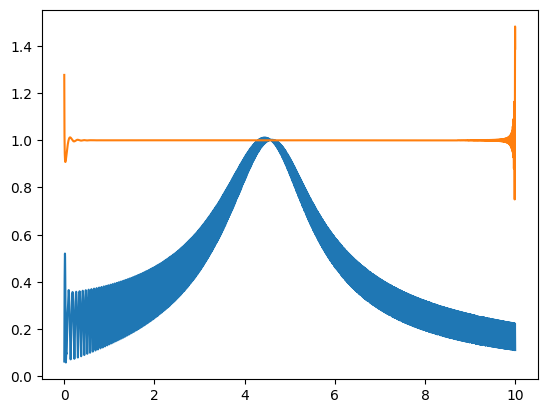

In [8]:
plt.plot(t, amp_est,label='OscillTrack')
plt.plot(t,true_amp,label = 'hilbert')

In [ ]:

# ---------------------------------------------------------------------
# 4. Simple accuracy check: RMS phase error ±1 s around 30 Hz crossing
# ---------------------------------------------------------------------
# Time at which chirp hits 30 Hz: solve 5 + (60-5)*(t/duration) = 30
t_hit = duration * (30 - 5) / (60 - 5)
idx = np.logical_and(t >= t_hit - 1, t <= t_hit + 1)
phase_err = np.angle(np.exp(1j * (phase_est[idx] - true_phase[idx])))
rms_err_deg = np.sqrt(np.mean(np.square(np.degrees(phase_err))))
print(f"RMS phase error around 30 Hz crossing: {rms_err_deg:.1f}°")


In [ ]:

# ---------------------------------------------------------------------
# Optional visual inspection
# ---------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.title("OscillTrack phase estimate vs. analytic phase")
plt.plot(t, np.unwrap(phase_est), label='OscillTrack')
plt.plot(t, true_phase, label='Hilbert', alpha=0.6)
plt.xlim(t_hit - 1, t_hit + 1)
plt.ylabel("Phase (rad)")
plt.legend()

plt.subplot(212)
plt.title("Amplitude envelope (est. vs. true)")
plt.plot(t, amp_est, label='OscillTrack')
plt.plot(t, true_amp, label='Hilbert', alpha=0.6)
plt.xlim(t_hit - 1, t_hit + 1)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

# Ground-truth phase around 30 Hz for comparison
analytic = hilbert(signal)
true_phase = np.unwrap(np.angle(analytic))
true_amp = np.abs(analytic)

# ---------------------------------------------------------------------
# 4. Simple accuracy check: RMS phase error ±1 s around 30 Hz crossing
# ---------------------------------------------------------------------
# Time at which chirp hits 30 Hz: solve 5 + (60-5)*(t/duration) = 30
t_hit = duration * (30 - 5) / (60 - 5)
idx = np.logical_and(t >= t_hit - 1, t <= t_hit + 1)
phase_err = np.angle(np.exp(1j * (phase_est[idx] - true_phase[idx])))
rms_err_deg = np.sqrt(np.mean(np.square(np.degrees(phase_err))))
print(f"RMS phase error around 30 Hz crossing: {rms_err_deg:.1f}°")

# ---------------------------------------------------------------------
# Optional visual inspection
# ---------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.title("OscillTrack phase estimate vs. analytic phase")
plt.plot(t, np.unwrap(phase_est), label='OscillTrack')
plt.plot(t, true_phase, label='Hilbert', alpha=0.6)
plt.xlim(t_hit - 1, t_hit + 1)
plt.ylabel("Phase (rad)")
plt.legend()

plt.subplot(212)
plt.title("Amplitude envelope (est. vs. true)")
plt.plot(t, amp_est, label='OscillTrack')
plt.plot(t, true_amp, label='Hilbert', alpha=0.6)
plt.xlim(t_hit - 1, t_hit + 1)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()